In [1]:
#from memory_profiler import profile
import fzMPI
from mpi4py import MPI

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

import compute_charge_dist as fz

%matplotlib inline

In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

In [3]:
fzMPI.print_to_logfile("Initializing clock.")

# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
#data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

yt : [INFO     ] 2018-07-31 18:25:22,240 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-07-31 18:25:22,262 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-07-31 18:25:22,262 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-07-31 18:25:22,263 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-07-31 18:25:22,264 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-07-31 18:25:22,278 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-07-31 18:25:22,279 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-07-31 18:25:22,280 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-07-31 18:25:22,281 Parameters: domain_righ

Initializing clock.


In [4]:
c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

In [5]:
min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

In [6]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))

In [7]:
wnmtrue = np.argwhere(wnm==True)

In [8]:
wnmindex = wnmtrue[0]

In [9]:
indexarr = np.array([wnmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])

In [10]:
GG = [fz.get_G(Av[0], G0=1.68)]

In [11]:
grain_type = "carbonaceous"
grain_size = [5, 100, 1000]
G0         = 1.68

Qabs5    = fz.get_QabsTable(grain_type, 5)
Qabs100  = fz.get_QabsTable(grain_type, 100)
Qabs1000 = fz.get_QabsTable(grain_type, 1000)

Qabs = [Qabs5, Qabs100, Qabs1000]

zmean, zmode, zstd  =  np.zeros(3), np.zeros(3), np.zeros(3)
zminmax = np.array(np.zeros(2*3))
fdist   = []
fdistCR   = []

# loop over grain sizes
for kk in range(3):
    # loop over ISM phases.
    for ii in range(1):
        
        print("Running grain size %i, phase %i"%(grain_size[kk], ii))
        
        zeta = fz.get_zeta(fH2shield[ii])

        ############################################################################################
        # Run the charge distribution calculation!!!
        Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Av[ii], grain_type, Qabs[kk], G0=G0)
        JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[ii], fH2shield[ii], zeta, grain_size[kk], grain_type, Qabs[kk])

        zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, grain_size[kk], grain_type)
        new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Av[ii], grain_type, Qabs[kk],fH2shield[ii], zeq=zeq, G0=1.68, includeCR=True)
        #new_zmin, new_zmax     = int(fz.get_Zmin(grain_size[ii], grain_type[ii])), int(fz.get_Zmax(grain_size[ii], grain_type[ii]))       
        
        if grain_size[kk] == 1000:
            new_zmax += 10
        
        ffz, ffzlog, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffzCR, ZZ              = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, ZZall, new_zmin, new_zmax)

        Zm        = fz.get_Zmode(ZZ, ffz)
        zmode[ii+kk] = Zm

        avg, std  = fz.weighted_avg_and_std(ZZ, ffz)
        zmean[ii+kk] = avg
        zstd[ii+kk]  = std

        print("Zmin index = %i"%(ii*2+  2*kk))
        print("zmin = %i"%(new_zmin))
        
        print("Zmax index = %i"%(ii*2+1+2*kk))
        print("zmax = %i"%(new_zmax))


        zminmax[ii*2+  2*kk]  = new_zmin
        zminmax[ii*2+1+2*kk]  = new_zmax
        
        print(zminmax)

        #fdist[ii]   = offset + ii
        for jj in range(len(ffz)):
            fdist.append(ffz[jj])
            
        print(ffz)
        print(ZZ)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Extrapolating is kinda not working so taking the Qabs, a=10 AA 
Running grain size 5, phase 0
Zmin index = 0
zmin = -1
Zmax index = 1
zmax = 13
[ -1.  13.   0.   0.   0.   0.]
[ 0.00276219  0.07089035  0.16175998  0.05526346  0.00042052  0.07089035
  0.07089035  0.07089035  0.07089035  0.07089035  0.07089035  0.07089035
  0.07089035  0.07089035  0.07089035]
[ -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.]
Running grain size 100, phase 0
Zmin index = 2
zmin = 31
Zmax index = 3
zmax = 66
[ -1.  13.  31.  66.   0.   0.]
[  1.81570301e-05   7.65751086e-05   2.89191131e-04   9.74575913e-04
   2.92136684e-03   7.75510198e-03   1.81212482e-02   3.71426998e-02
   6.64967868e-02   1.03292299e-01   1.38459655e-01   1.59199893e-01
   1.55996089e-01   1.29256867e-01   8.98499768e-02   5.19287012e-02
   2.47201331e-02   9.59070322e-03   2.99706316e-03   7.44141002e-04
   1.44548222e-04  

In [12]:
grain_type = "silicate"
grain_size = [5, 100, 1000]
G0         = 1.68

Qabs5    = fz.get_QabsTable(grain_type, 5)
Qabs100  = fz.get_QabsTable(grain_type, 100)
Qabs1000 = fz.get_QabsTable(grain_type, 1000)

Qabs = [Qabs5, Qabs100, Qabs1000]

zmean_sil, zmode_sil, zstd_sil  =  np.zeros(3), np.zeros(3), np.zeros(3)
zminmax_sil = np.array(np.zeros(2*3))
fdist_sil   = []


# loop over grain sizes
for kk in range(3):
    # loop over ISM phases.
    for ii in range(1):
        
        print("Running grain size %i, phase %i"%(grain_size[kk], ii))
        
        zeta = fz.get_zeta(fH2shield[ii])

        ############################################################################################
        # Run the charge distribution calculation!!!
        Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Av[ii], grain_type, Qabs[kk], G0=G0)
        JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[ii], fH2shield[ii], zeta, grain_size[kk], grain_type, Qabs[kk])

        zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, grain_size[kk], grain_type)
        new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Av[ii], grain_type, Qabs[kk],fH2shield[ii], zeq=zeq, G0=1.68, includeCR=True)
        #new_zmin, new_zmax     = int(fz.get_Zmin(grain_size[ii], grain_type[ii])), int(fz.get_Zmax(grain_size[ii], grain_type[ii]))       
        
        if grain_size[kk] == 1000:
            new_zmax += 10
        
        ffz, ffzlog, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffzCR, ZZ              = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, ZZall, new_zmin, new_zmax)

        Zm        = fz.get_Zmode(ZZ, ffz)
        zmode_sil[ii+kk] = Zm

        avg, std  = fz.weighted_avg_and_std(ZZ, ffz)
        zmean_sil[ii+kk] = avg
        zstd_sil[ii+kk]  = std

        print("Zmin index = %i"%(ii*2+  2*kk))
        print("zmin = %i"%(new_zmin))
        
        print("Zmax index = %i"%(ii*2+1+2*kk))
        print("zmax = %i"%(new_zmax))


        zminmax_sil[ii*2+  2*kk]  = new_zmin
        zminmax_sil[ii*2+1+2*kk]  = new_zmax
        
        print(zminmax)

        #fdist[ii]   = offset + ii
        for jj in range(len(ffz)):
            fdist_sil.append(ffz[jj])
            
        print(ffz)
        print(ZZ)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Extrapolating is kinda not working so taking the Qabs, a=10 AA 
Running grain size 5, phase 0
Zmin index = 0
zmin = -1
Zmax index = 1
zmax = 12
[  -1.   13.   31.   66.  321.  410.]
[ 0.00355258  0.08344051  0.07822075  0.00038101  0.08344051  0.08344051
  0.08344051  0.08344051  0.08344051  0.08344051  0.08344051  0.08344051
  0.08344051  0.08344051]
[ -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]
Running grain size 100, phase 0
Zmin index = 2
zmin = 15
Zmax index = 3
zmax = 45
[  -1.   13.   31.   66.  321.  410.]
[  7.24521052e-06   5.14876165e-05   3.01669094e-04   1.45016704e-03
   5.69103839e-03   1.81237899e-02   4.65000459e-02   9.54058882e-02
   1.55182294e-01   1.98108649e-01   1.96207678e-01   1.48695821e-01
   8.48673537e-02   3.57951580e-02   1.09042657e-02   2.33419666e-03
   3.39262795e-04   3.20646037e-05   1.86226130e-06   6.15567437e-08
   1.03799005e-09   7.54

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Zmin index = 4
zmin = 170
Zmax index = 5
zmax = 241
[  -1.   13.   31.   66.  321.  410.]
[  3.34882886e-05   5.89036871e-05   1.01375135e-04   1.70704998e-04
   2.81237286e-04   4.53311906e-04   7.14832454e-04   1.10361518e-03
   1.66654662e-03   2.46142969e-03   3.55558658e-03   5.02311785e-03
   6.93997350e-03   9.37666198e-03   1.23887644e-02   1.60058927e-02
   2.02202515e-02   2.49765600e-02   3.01647688e-02   3.56180355e-02
   4.11171849e-02   4.64244144e-02   5.12358976e-02   5.52697305e-02
   5.82727285e-02   6.00465097e-02   6.04691004e-02   5.95087789e-02
   5.72279750e-02   5.37765684e-02   4.93755604e-02   4.42936739e-02
   3.88202428e-02   3.32440181e-02   2.78092623e-02   2.27227631e-02
   1.81344201e-02   1.41348885e-02   1.07597147e-02   7.99837471e-03
   5.80587641e-03   4.11526432e-03   2.84793569e-03   1.92413727e-03
   1.26907046e-03   8.17050778e-04   5.13446550e-04   3.14918715e-04
   1.88503803e-04   1.10110238e-04   6.27607518e-05   3.49034488e-05
   1.89380216

In [13]:
print(fdist)

[0.0027621881591757009, 0.070890350080113407, 0.16175998135802341, 0.055263463824905878, 0.0004205157766475046, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 0.070890350080113407, 1.8157030129162717e-05, 7.6575108581555196e-05, 0.00028919113069676391, 0.00097457591341108092, 0.0029213668402315583, 0.0077551019796363559, 0.01812124820407663, 0.037142699831407194, 0.066496786774748892, 0.10329229916942037, 0.13845965541547248, 0.1591998927269058, 0.15599608852230698, 0.12925686720043095, 0.089849976763112113, 0.051928701169130696, 0.02472013314194399, 0.0095907032217676918, 0.002997063162869908, 0.00074414100215489749, 0.00014454822158800487, 2.1586556587964309e-05, 2.4279460913916626e-06, 2.0063993264656144e-07, 1.1834048866504641e-08, 4.8028358711868072e-10, 1.2818472343235743e-11, 2.1204872429604523e-13, 2.0069548954198455e-15, 9.69567

In [15]:
# From bottom left, to upper right.
ii = 0
jj = 0

# Start the cumulative count.
cum = 0
cum_sil = 0

########## 5AA WNM

##############################
zmin = zminmax[0 + 2*ii]
zmax = zminmax[1 + 2*ii]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

zmin = zminmax_sil[0 + 2*ii]
zmax = zminmax_sil[1 + 2*ii]
charges_sil = int(zmax-zmin)
ffz_sil = np.array(fdist_sil[cum_sil:cum_sil+charges_sil+1])
zmin, zmax = zmin-1, zmax+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin, zmax+1) 

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################


newzmean     = np.sum(ZZ[0:6]*(ffz[0:6]/np.sum(ffz[0:6])))
newstd       = np.sqrt(np.sum(ffz[0:6]/np.sum(ffz[0:6])*(ZZ[0:6] - newzmean)**2))

In [37]:
print(ZZ[0:6])
print(ffz[0:6])
normfz = ffz[0:6] / (np.sum(ffz[0:6]))
print(normfz)
print(np.sum(ZZ[0:6]*normfz))

print(newzmean)
print(newstd)

[-2. -1.  0.  1.  2.  3.]
[ 0.          0.00276219  0.07089035  0.16175998  0.05526346  0.00042052]
[ 0.          0.00948891  0.24352869  0.55569195  0.18984586  0.00144459]
0.930228528766
0.930228528766
0.687197566393


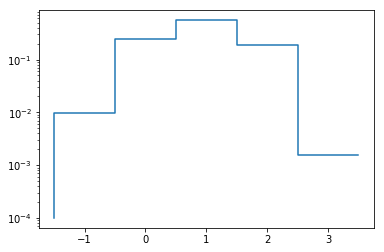

In [41]:
plt.semilogy(ZZ[0:6]+0.5, normfz+1.0e-4, drawstyle='steps')

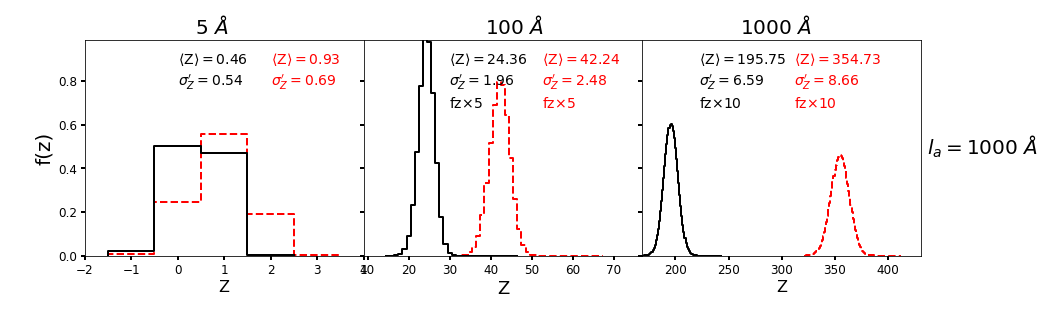

In [46]:
xsize = 14
ysize = 4

nfigs_x = 3
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.054

xs_panel = 0.83 / nfigs_x 
ys_panel = 0.75 / nfigs_y 

############################################################################################################
############################               5 Angstroms             #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.text(0.18, 0.92, "5 $\\AA$", fontsize=20, horizontalalignment='center')
ax.text(0.48, 0.92, "100 $\\AA$", fontsize=20, horizontalalignment='center')
ax.text(0.74, 0.92,"1000 $\\AA$", fontsize=20, horizontalalignment='center')

ax.text(0.945, 0.5, "$l_{a} = 1000$ $\\AA$ ", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

# Start the cumulative count.
cum = 0
cum_sil = 0

########## 5AA WNM

##############################
zmin = zminmax[0 + 2*ii]
zmax = zminmax[1 + 2*ii]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

zmin = zminmax_sil[0 + 2*ii]
zmax = zminmax_sil[1 + 2*ii]
charges_sil = int(zmax-zmin)
ffz_sil = np.array(fdist_sil[cum_sil:cum_sil+charges_sil+1])
zmin, zmax = zmin-1, zmax+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin, zmax+1) 

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)


#carbon
ax.plot(ZZ[0:6]+0.5, ffz[0:6]/np.sum(ffz[0:6]), "--r", linewidth=2, drawstyle='steps', alpha=1.0)

ax.plot(ZZ_sil[0:5]+0.5, ffz_sil[0:5]/np.sum(ffz_sil[0:5]), "-k", linewidth=2, drawstyle='steps', alpha=1.0)


zmin = min(ZZ[0], ZZ_sil[0])

newzmean     = np.sum(ZZ[0:6]*(ffz[0:6]/np.sum(ffz[0:6])))
newstd       = np.sqrt(np.sum(ffz[0:6]/np.sum(ffz[0:6])*(ZZ[0:6] - newzmean)**2))
                          
newzmean_sil = np.sum(ZZ_sil[0:5]*ffz_sil[0:5]/np.sum(ffz_sil[0:5]))
newstd_sil   = np.sqrt(np.sum(ffz_sil[0:5]/np.sum(ffz_sil[0:5])*(ZZ_sil[0:5] - newzmean_sil)**2))
                          

ax.text(2, 0.88, "$\\langle$Z$\\rangle =%.2f$"%newzmean, fontsize=14, color='red')
ax.text(2, 0.78, "$\\sigma_{Z}\'=%.2f$"%newstd, fontsize=14, color='red')

ax.text(0, 0.88, "$\\langle$Z$\\rangle =%.2f$"%newzmean_sil, fontsize=14)
ax.text(0, 0.78, "$\\sigma_{Z}\'=%.2f$"%newstd_sil, fontsize=14)


ax.set_ylim(0, 0.99)
ax.set_xlim(-2,4)


ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("f(z)", fontsize=20)
ax.set_xlabel("Z", fontsize=16)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)



############################################################################################################
############################                100 Angstroms            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

########## 100AA WNM

##############################
zmin = zminmax[0 + 2*ii]
zmax = zminmax[1 + 2*ii]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

zmin = zminmax_sil[0 + 2*ii]
zmax = zminmax_sil[1 + 2*ii]
charges_sil = int(zmax-zmin)
ffz_sil = np.array(fdist_sil[cum_sil:cum_sil+charges_sil+1])
zmin, zmax = zmin-1, zmax+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin, zmax+1) 

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

ax.plot(ZZ+0.5, ffz*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)
ax.plot(ZZ_sil+0.5, ffz_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)


zmin = min(ZZ[0], ZZ_sil[0])

ax.text(1.1*charges + zmin, 0.88, "$\\langle$Z$\\rangle =%.2f$"%zmean[ii], fontsize=14, color='red')
ax.text(1.1*charges + zmin, 0.78, "$\\sigma_{Z}\'=%.2f$"%zstd[ii], fontsize=14, color='red')
ax.text(1.1*charges + zmin, 0.68, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.45*charges + zmin, 0.88, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[ii], fontsize=14, color='black')
ax.text(0.45*charges + zmin, 0.78, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[ii], fontsize=14, color='black')
ax.text(0.45*charges + zmin, 0.68, "fz$\\times$5", fontsize=14, color='black')


#ax.set_xlim(np.min(Z_a_3_100)+0.1, np.max(Z_a_3_100)-0.1)
ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0])-5, max(ZZ[-1], ZZ_sil[-1])+10)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("Z", fontsize=18)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)



############################################################################################################
############################               1000 Angstroms            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0

##############################
zmin = zminmax[0 + 2*ii]
zmax = zminmax[1 + 2*ii]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1)

zmin = zminmax_sil[0 + 2*ii]
zmax = zminmax_sil[1 + 2*ii]
charges_sil = int(zmax-zmin)
ffz_sil = np.array(fdist_sil[cum_sil:cum_sil+charges_sil+1])
zmin, zmax = zmin-1, zmax+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin, zmax+1) 

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])


ax.plot(ZZ+0.5, ffz*10, "--r", linewidth=2, drawstyle='steps', alpha=1.0)
ax.plot(ZZ_sil+0.5, ffz_sil*10, "-k", linewidth=2, drawstyle='steps', alpha=1.0)


zmin = min(ZZ[0], ZZ_sil[0])

ax.text(1.6*charges + zmin, 0.88, "$\\langle$Z$\\rangle =%.2f$"%zmean[ii], fontsize=14, color='red')
ax.text(1.6*charges + zmin, 0.78, "$\\sigma_{Z}\'=%.2f$"%zstd[ii], fontsize=14, color='red')
ax.text(1.6*charges + zmin, 0.68, "fz$\\times$10", fontsize=14, color='red')


ax.text(0.6*charges + zmin, 0.88, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[ii], fontsize=14, color='black')
ax.text(0.6*charges + zmin, 0.78, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[ii], fontsize=14, color='black')
ax.text(0.6*charges + zmin, 0.68, "fz$\\times$10", fontsize=14, color='black')


ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1])+20)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("Z", fontsize=16)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Apendix/Appendix_attenuationlength_1000.pdf", format="pdf")

